In [15]:
import os,sys
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import xarray as xr
import rasterio
import numpy as np
import pyproj
from pygeos import from_wkb,from_wkt
import pygeos
from tqdm import tqdm
from shapely.wkb import loads
from pathlib import Path
import glob
from shapely.geometry import mapping
pd.options.mode.chained_assignment = None
from rasterio.mask import mask
import rioxarray
import matplotlib.pyplot as plt
from scipy import integrate
from collections.abc import Iterable
import openpyxl
from openpyxl import Workbook

import warnings
warnings.filterwarnings("ignore")

from scipy import integrate

In [6]:
data_path = os.path.join('C:\\','Data','pg_risk_analysis')
tc_path = os.path.join(data_path,'tc_netcdf')
fl_path = os.path.join(data_path,'GLOFRIS')
osm_data_path = os.path.join('C:\\','Data','country_osm')
pg_data_path = os.path.join(data_path,'pg_data')
vul_curve_path = os.path.join(data_path,'vulnerability_curves','input_vulnerability_data.xlsx')
output_path = os.path.join('C:\\','projects','pg_risk_analysis_output','output')
ne_path = os.path.join(data_path,'..',"natural_earth","ne_10m_admin_0_countries.shp")

In [21]:
def assess_damage_osm(country_code,osm_power_infra,hazard_type): #NEW VERSION
    # set paths
    #data_path,tc_path,fl_path,osm_data_path,pg_data_path,vul_curve_path,output_path,ne_path = set_paths()
    
    # read infrastructure data:
    osm_lines,osm_poly,osm_points = osm_power_infra

    if hazard_type=='tc':
        # read wind data
        climate_models = ['','_CMCC-CM2-VHR4','_CNRM-CM6-1-HR','_EC-Earth3P-HR','_HadGEM3-GC31-HM']
        df_ds = open_storm_data(country_code)

        # remove assets that will not have any damage
        osm_lines = osm_lines.loc[osm_lines.asset != 'cable'].reset_index(drop=True)
        osm_lines['asset'] = osm_lines['asset'].replace(['minor_line'], 'line')
        osm_poly = osm_poly.loc[osm_poly.asset != 'plant'].reset_index(drop=True)            
    
    elif hazard_type=='fl':
        # read flood data
        climate_models = ['historical','rcp8p5']
        df_ds = open_flood_data(country_code)
        
    for climate_model in climate_models:
        # assess damage for lines
        #print(df_ds[climate_model])
        #print(overlay_hazard_assets(df_ds[climate_model],osm_lines).T)
        overlay_lines = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_lines).T,
                                     columns=['asset','hazard_point'])
        
        overlay_lines_new = overlay_lines
        overlay_lines_new['geometry'] = None
        for index, row in overlay_lines_new.iterrows():
            hazard_point = row['hazard_point']
            geometry = df_ds[climate_model].loc[hazard_point, 'geometry']
            overlay_lines_new.at[index, 'geometry'] = geometry
            
        overlay_lines_new.to_excel(os.path.join(output_path,f'{country_code}_overlay_lines_{climate_model}.xlsx'))

        # assess damage for polygons
        if len(osm_poly) > 0:
            overlay_poly = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_poly).T,
                                    columns=['asset','hazard_point'])
        else:
            overlay_poly = pd.DataFrame()
        
        overlay_poly_new = overlay_poly
        overlay_poly_new['geometry'] = None
        for index, row in overlay_poly_new.iterrows():
            hazard_point = row['hazard_point']
            geometry = df_ds[climate_model].loc[hazard_point, 'geometry']
            overlay_poly_new.at[index, 'geometry'] = geometry

        #assess damage for points
        overlay_points = pd.DataFrame(overlay_hazard_assets(df_ds[climate_model],osm_points).T,
                                      columns=['asset','hazard_point'])
        overlay_points.to_excel(os.path.join(output_path,f'{country_code}_overlay_points_{climate_model}.xlsx'))

    return damaged_lines,damaged_poly,damaged_points

In [23]:
osm_power_infra = extract_osm_infrastructure('KHM',osm_data_path)

query is finished, lets start the loop


extract: 0it [00:00, ?it/s]


TypeError: 'NoneType' object is not iterable

In [11]:
df = pd.read_excel(os.path.join(output_path,'KHM_overlay_lines_.xlsx'))
df

,Unnamed: 0,asset,hazard_point,geometry
0,0,0,3391,"POLYGON ((11966845.26 1574216.548, 11966845.26..."
1,1,1,1589,"POLYGON ((11677414.584 1300219.208, 11677414.5..."
2,2,2,917,"POLYGON ((11610622.89 1198103.041, 11610622.89..."
3,3,3,916,"POLYGON ((11599490.941 1198103.041, 11599490.9..."
4,4,3,917,"POLYGON ((11610622.89 1198103.041, 11610622.89..."
...,...,...,...,...
346,346,111,2115,"POLYGON ((11766470.177 1379869.508, 11766470.1..."
347,347,111,2114,"POLYGON ((11755338.228 1379869.508, 11755338.2..."
348,348,111,2189,"POLYGON ((11766470.177 1391265.162, 11766470.1..."
349,349,111,2188,"POLYGON ((11755338.228 1391265.162, 11755338.2..."


In [10]:
# 根据hazard_point计算每个hazard_point对应的asset个数
hazard_counts = df.groupby('hazard_point')['asset'].nunique().reset_index()
hazard_counts.columns = ['hazard_point', 'asset_count']

# 从原始DataFrame中获取每个hazard_point对应的geometry
hazard_geometry = df[['hazard_point', 'geometry']].drop_duplicates()

# 合并两个DataFrame，创建新的DataFrame
new_df = pd.merge(hazard_counts, hazard_geometry, on='hazard_point')

# 输出新的DataFrame
new_df

,hazard_point,asset_count,geometry
0,840,1,"POLYGON ((11577227.043 1186775.975, 11577227.0..."
1,841,1,"POLYGON ((11588358.992 1186775.975, 11588358.9..."
2,842,1,"POLYGON ((11599490.941 1186775.975, 11599490.9..."
3,910,1,"POLYGON ((11532699.246 1198103.041, 11532699.2..."
4,913,1,"POLYGON ((11566095.093 1198103.041, 11566095.0..."
...,...,...,...
209,3376,2,"POLYGON ((11799866.024 1574216.548, 11799866.0..."
210,3377,2,"POLYGON ((11810997.973 1574216.548, 11810997.9..."
211,3391,1,"POLYGON ((11966845.26 1574216.548, 11966845.26..."
212,3449,2,"POLYGON ((11788734.075 1585691.789, 11788734.0..."


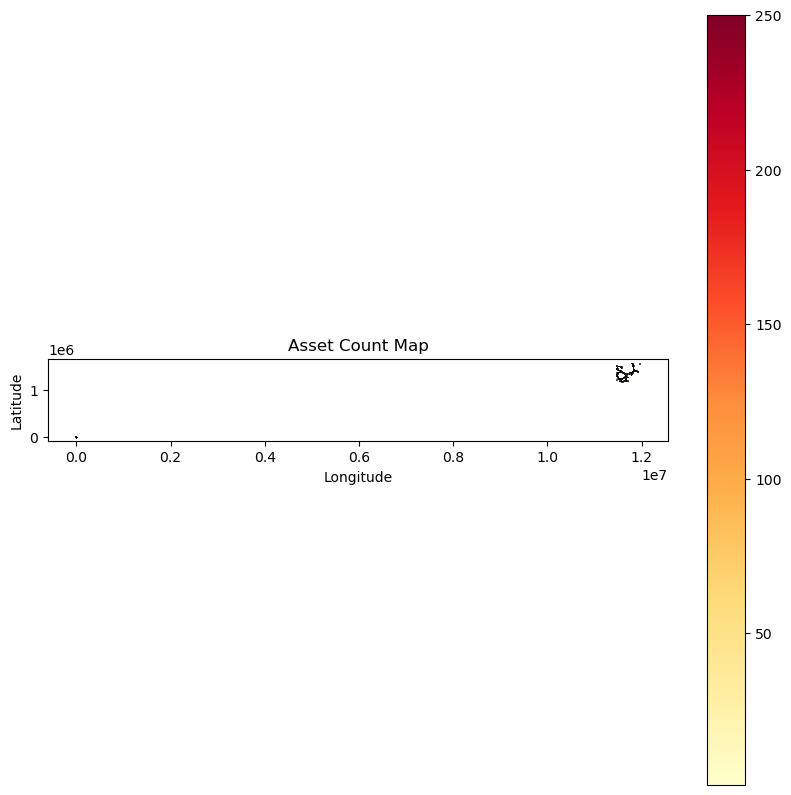

In [31]:
new_df = pd.read_excel(os.path.join(output_path,'KHM_osm_exposure_tc.xlsx'))

# 将geometry列转换为Geopandas的几何对象
new_df['geometry'] = gpd.GeoSeries.from_wkt(new_df['geometry'])

# 创建Geopandas的GeoDataFrame
gdf = gpd.GeoDataFrame(new_df,geometry='geometry')

ne_countries = gpd.read_file('C:/Users/mye500/OneDrive - Vrije Universiteit Amsterdam/01_Research-Projects/01_risk_assessment/base_map/base_map_adm_0.gpkg')

#merged = gpd.sjoin(ne_countries, gdf, how='inner', op='intersects')
#print(merged)

# 绘制地图
fig, ax = plt.subplots(figsize=(10, 10))

ne_countries.plot(ax=ax, color='lightgray', edgecolor='black')
gdf.plot(ax=ax, column='asset_count', cmap='YlOrRd', edgecolor='black', linewidth=0.5, legend=True)

# 设置图标题和坐标轴标签
ax.set_title('Asset Count Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# 显示图形
plt.show()
